# Notebook for inferring predictions and comparing model performance

## Import models and functions needed

In [10]:
import json
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import log_loss
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import colorcet as cc
import seaborn as sns

from model_definitions import KmerCountsModel, FCNNEmbedding, ModularModel
from utils.load_splits import load_splits
from utils.decode_kmer import decode_kmer


MODEL_VERSION = "A"

## Iterate over data versions, load in both benchmark and neural network models, predict over test set, save losses in dictionary

In [11]:
with open("/faststorage/project/MutationAnalysis/Nimrod/results/log_losses_benchmark_fc_models.json") as f:
    benchmark_fc_losses = json.load(f)

In [12]:
rows = []

for model, data_versions in benchmark_fc_losses.items():
    for data_version, loss in data_versions.items():
        rows.append({
            "model": model,
            "data_version": data_version,
            "loss": loss
        })

benchmark_fc_losses_df = pd.DataFrame(rows)
benchmark_fc_losses_df = benchmark_fc_losses_df[benchmark_fc_losses_df["data_version"].str.endswith(MODEL_VERSION)]

In [13]:
# Select across which data versions you want to evaluate
losses_df = benchmark_fc_losses_df[benchmark_fc_losses_df["data_version"].str.startswith(("3", "5", "7"))]

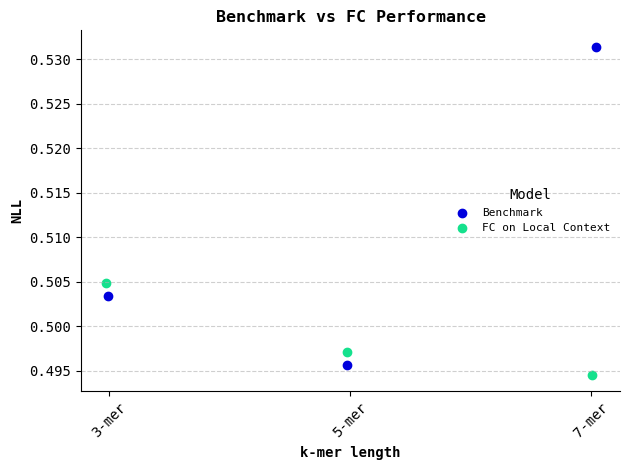

In [37]:
plt.rcParams.update({'font.family': 'monospace'})

x_labels = ["3-mer", "5-mer", "7-mer"]
x_label_map = {"3fA": 0, "5fA": 1, "7fA": 2}
jitter = 0.025

colors = {
    "benchmark": mpl.colormaps['cet_glasbey_dark'].colors[10],
    "fc": mpl.colormaps['cet_glasbey_dark'].colors[9]
}

legend_title = {
    "benchmark": "Benchmark",
    "fc": "FC on Local Context"
}

fig, ax = plt.subplots()

for model in losses_df["model"].unique():
    model_df = losses_df[losses_df["model"] == model]

    # Map data_version to x-axis positions
    x_vals = model_df["data_version"].map(x_label_map).astype(float)
    x_vals += np.random.uniform(-jitter, jitter, size=len(x_vals))

    ax.scatter(
        x=x_vals,
        y=model_df["loss"],
        color=colors[model],
        label=legend_title[model]
    )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.6, zorder=0)
ax.set_title("Benchmark vs FC Performance", fontweight='bold')
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("k-mer length", fontweight='bold')
ax.set_ylabel("NLL", fontweight='bold')
ax.legend(title="Model", loc='center right', fontsize=8, frameon=False)

plt.tight_layout()
plt.show()

## FC on local context alone vs FC on local context plus bin ID

In [18]:
with open("/faststorage/project/MutationAnalysis/Nimrod/results/log_losses_combined_models_05-27_17-51-48.json") as f:
    all_losses = json.load(f)

rows = []

for model, data_versions in all_losses.items():
    for data_version, bin_sizes in data_versions.items():
        for bin_size, loss in bin_sizes.items():
            rows.append({
                "model": model,
                "data_version": data_version,
                "bin_size": bin_size,
                "loss": loss
            })

combined_losses_df = pd.DataFrame(rows)
combined_losses_df = combined_losses_df[combined_losses_df["data_version"].str.endswith(MODEL_VERSION)]

In [19]:
benchmark_fc_losses_df.head()

,model,data_version,loss
2,benchmark,3fA,0.503445
3,benchmark,7fA,0.531394
6,benchmark,5fA,0.495656
7,benchmark,9fA,1.683015
9,benchmark,11fA,4.145778


In [20]:
combined_losses_df.head()

,model,data_version,bin_size,loss
0,avgmut,3fA,100kb,0.378276
1,avgmut,3fA,500kb,0.476493
2,avgmut,3fA,1mb,0.497779
6,avgmut,5fA,100kb,0.372268
7,avgmut,5fA,500kb,0.470326


In [ ]:
# Concatenate the two sources of loss results
all_losses_df = pd.concat([benchmark_fc_losses_df, combined_losses_df], ignore_index=True)

In [24]:
all_losses_df["model"].unique()

array(['benchmark', 'fc', 'avgmut', 'avgmut_binnorm',
       'avgmut_binid_binnorm', 'binid', 'binnorm'], dtype=object)

In [27]:
fc_context_binid_df = all_losses_df[all_losses_df["model"].str.startswith(("fc", "binid"))]
fc_context_binid_df = fc_context_binid_df[fc_context_binid_df["bin_size"].isin([None, "100kb"])]

In [28]:
fc_context_binid_df

,model,data_version,loss,bin_size
7,fc,3fA,0.504905,NaN
8,fc,7fA,0.494536,NaN
9,fc,5fA,0.497066,NaN
10,fc,9fA,0.493778,NaN
11,fc,11fA,0.492890,NaN
12,fc,13fA,0.492953,NaN
13,fc,15fA,0.493205,NaN
77,binid,3fA,0.503911,100kb
80,binid,5fA,0.496776,100kb
83,binid,7fA,0.494885,100kb


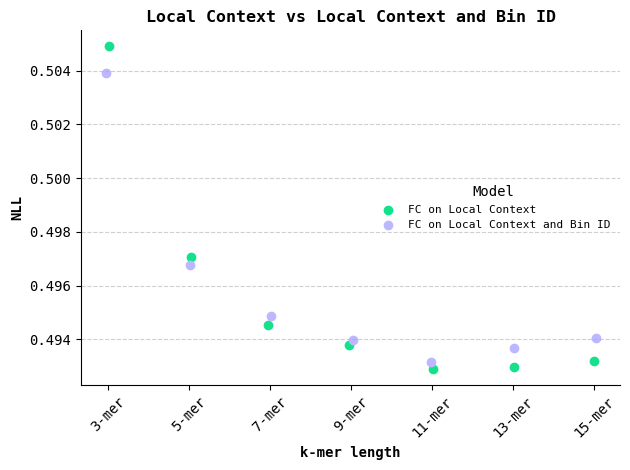

In [36]:
plt.rcParams.update({'font.family': 'monospace'})

x_labels = ["3-mer", "5-mer", "7-mer", "9-mer", "11-mer", "13-mer", "15-mer"]
x_label_map = {"3fA": 0, "5fA": 1, "7fA": 2, "9fA": 3, "11fA": 4, "13fA": 5, "15fA": 6}
jitter = 0.025

colors = {
    "fc": mpl.colormaps['cet_glasbey_dark'].colors[9],
    "binid": mpl.colormaps['cet_glasbey_dark'].colors[12]
}

legend_title = {
    "fc": "FC on Local Context",
    "binid": "FC on Local Context and Bin ID",
}

fig, ax = plt.subplots()

for model in fc_context_binid_df["model"].unique():
    model_df = fc_context_binid_df[fc_context_binid_df["model"] == model]

    # Map data_version to x-axis positions
    x_vals = model_df["data_version"].map(x_label_map).astype(float)
    x_vals += np.random.uniform(-jitter, jitter, size=len(x_vals))

    ax.scatter(
        x=x_vals,
        y=model_df["loss"],
        color=colors[model],
        label=legend_title[model]
    )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.6, zorder=0)
ax.set_title("Local Context vs Local Context and Bin ID", fontweight='bold')
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("k-mer length", fontweight='bold')
ax.set_ylabel("NLL", fontweight='bold')
ax.legend(title="Model", loc='center right', fontsize=8, frameon=False)

plt.tight_layout()
plt.show()

## Compare NNs using different features and different bin sizes

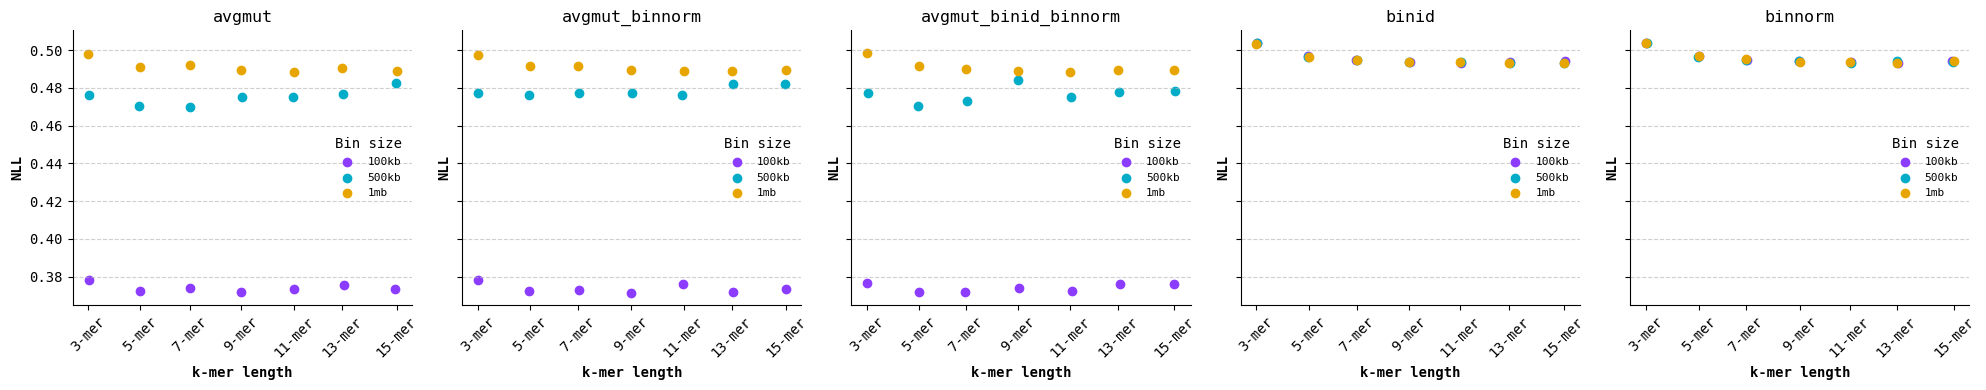

In [21]:
plt.rcParams.update({'font.family': 'monospace'})

x_labels = ["3-mer", "5-mer", "7-mer", "9-mer", "11-mer", "13-mer", "15-mer"]
x_vals = np.arange(len(x_labels)) # Convert labels to integers

binsize_order = ["100kb", "500kb", "1mb"]
combined_losses_df["bin_size"] = pd.Categorical(combined_losses_df["bin_size"], categories=binsize_order, ordered=True)

# Obtain number of different feature sets to group by and facet later
feature_sets = combined_losses_df["model"].unique()
n_feature_sets = len(feature_sets)

colors = {"100kb": mpl.colormaps['cet_glasbey_dark'].colors[1], "500kb": mpl.colormaps['cet_glasbey_dark'].colors[3], "1mb": mpl.colormaps['cet_glasbey_dark'].colors[4]}
# colors = mpl.colormaps['cet_glasbey_dark'].colors
# colors = cc.m_glasbey_dark
jitter = 0.025

fig, axes = plt.subplots(nrows=1, ncols=n_feature_sets, figsize=(4 * n_feature_sets, 4), sharey=True)

for index, (ax, model) in enumerate(zip(axes, feature_sets)):
    sub_df = combined_losses_df[combined_losses_df["model"] == model]

    for bin_size, group in sub_df.groupby("bin_size", observed=True):
        x_vals = x_vals + np.random.uniform(-jitter, jitter, size=len(x_vals))
        ax.scatter(
            x=x_vals,
            y=group["loss"],
            label=bin_size,
            color=colors[bin_size]
        )
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.6, zorder = 0)
    ax.set_title(model)
    ax.set_xticks(x_vals)
    ax.set_xticklabels(x_labels)
    ax.tick_params(axis="x", rotation=45)
    # ax.legend(title="Bin size")
    ax.legend(title="Bin size", loc='center right', fontsize=8, frameon=False)
    ax.set_xlabel('k-mer length', fontweight='bold')
    ax.set_ylabel('NLL', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Out of the figures above, I need to put "binid" and "binnorm" side by side
# "avgmut" vs "binnorm" vs both

## Bin ID vs bin normalized

/tmp/ipykernel_1992768/2943994982.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["bin_size"] = pd.Categorical(temp_df["bin_size"], categories=binsize_order, ordered=True)


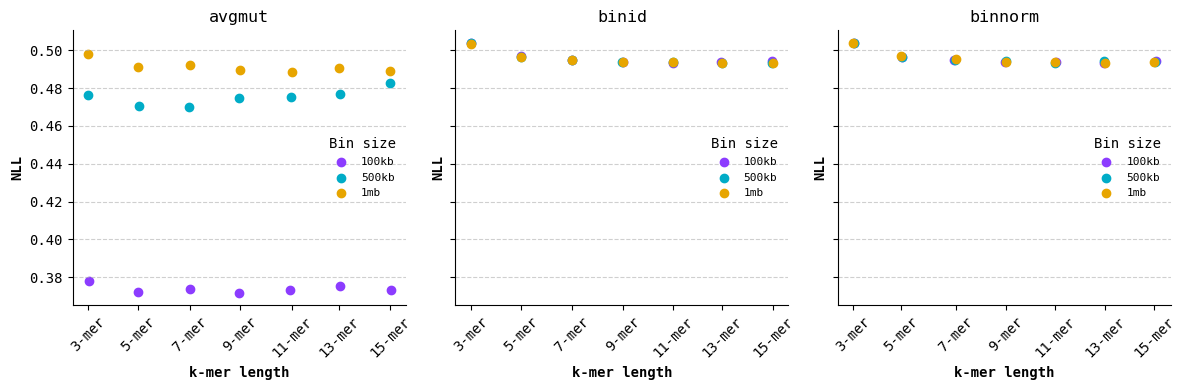

In [40]:
temp_df = combined_losses_df[(combined_losses_df["model"] == "binid") | (combined_losses_df["model"] == "binnorm") | (combined_losses_df["model"] == "avgmut")]

plt.rcParams.update({'font.family': 'monospace'})

x_labels = ["3-mer", "5-mer", "7-mer", "9-mer", "11-mer", "13-mer", "15-mer"]
x_vals = np.arange(len(x_labels)) # Convert labels to integers

binsize_order = ["100kb", "500kb", "1mb"]
temp_df["bin_size"] = pd.Categorical(temp_df["bin_size"], categories=binsize_order, ordered=True)

# Obtain number of different feature sets to group by and facet later
feature_sets = temp_df["model"].unique()
n_feature_sets = len(feature_sets)

colors = {"100kb": mpl.colormaps['cet_glasbey_dark'].colors[1], "500kb": mpl.colormaps['cet_glasbey_dark'].colors[3], "1mb": mpl.colormaps['cet_glasbey_dark'].colors[4]}
# colors = mpl.colormaps['cet_glasbey_dark'].colors
# colors = cc.m_glasbey_dark
jitter = 0.025

fig, axes = plt.subplots(nrows=1, ncols=n_feature_sets, figsize=(4 * n_feature_sets, 4), sharey=True)

for index, (ax, model) in enumerate(zip(axes, feature_sets)):
    sub_df = temp_df[temp_df["model"] == model]

    for bin_size, group in sub_df.groupby("bin_size", observed=True):
        x_vals = x_vals + np.random.uniform(-jitter, jitter, size=len(x_vals))
        ax.scatter(
            x=x_vals,
            y=group["loss"],
            label=bin_size,
            color=colors[bin_size]
        )
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.6, zorder = 0)
    ax.set_title(model)
    ax.set_xticks(x_vals)
    ax.set_xticklabels(x_labels)
    ax.tick_params(axis="x", rotation=45)
    # ax.legend(title="Bin size")
    ax.legend(title="Bin size", loc='center right', fontsize=8, frameon=False)
    ax.set_xlabel('k-mer length', fontweight='bold')
    ax.set_ylabel('NLL', fontweight='bold')

plt.tight_layout()
plt.show()

## Read in results of models with overall avg mut rate

In [47]:
with open("/faststorage/project/MutationAnalysis/Nimrod/results/log_losses_combined_models.json", "r") as f:
    overall_avg_mut_results = json.load(f)

rows = []

for model, data_versions in overall_avg_mut_results.items():
    for data_version, bin_sizes in data_versions.items():
        for bin_size, loss in bin_sizes.items():
            rows.append({
                "model": model,
                "data_version": data_version,
                "bin_size": bin_size,
                "loss": loss
            })

overall_avg_mut_results_df = pd.DataFrame(rows)
overall_avg_mut_results_df = overall_avg_mut_results_df[(overall_avg_mut_results_df["data_version"].str.endswith(MODEL_VERSION)) & (overall_avg_mut_results_df["model"] == "avgmut") & (overall_avg_mut_results_df["bin_size"] == "100kb")]

In [49]:
overall_avg_mut_results_df["model"] = "overall_" + overall_avg_mut_results_df["model"]

In [50]:
overall_avg_mut_results_df

,model,data_version,bin_size,loss
0,overall_avgmut,3fA,100kb,0.447597
6,overall_avgmut,5fA,100kb,0.443248
12,overall_avgmut,7fA,100kb,0.441937
18,overall_avgmut,9fA,100kb,0.441153
24,overall_avgmut,11fA,100kb,0.441422
30,overall_avgmut,13fA,100kb,0.442732
36,overall_avgmut,15fA,100kb,0.440197


In [55]:
typespec_avgmut_df = combined_losses_df[(combined_losses_df["model"] == "avgmut") & (combined_losses_df["bin_size"] == "100kb")]
typespec_avgmut_df["model"] = "typespec_" + typespec_avgmut_df["model"]
overall_vs_typespec_avgmut_df = pd.concat([overall_avg_mut_results_df, typespec_avgmut_df], ignore_index=True)

/tmp/ipykernel_1992768/1135213868.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  typespec_avgmut_df["model"] = "typespec_" + typespec_avgmut_df["model"]


In [56]:
overall_vs_typespec_avgmut_df

,model,data_version,bin_size,loss
0,overall_avgmut,3fA,100kb,0.447597
1,overall_avgmut,5fA,100kb,0.443248
2,overall_avgmut,7fA,100kb,0.441937
3,overall_avgmut,9fA,100kb,0.441153
4,overall_avgmut,11fA,100kb,0.441422
5,overall_avgmut,13fA,100kb,0.442732
6,overall_avgmut,15fA,100kb,0.440197
7,typespec_avgmut,3fA,100kb,0.378276
8,typespec_avgmut,5fA,100kb,0.372268
9,typespec_avgmut,7fA,100kb,0.374004


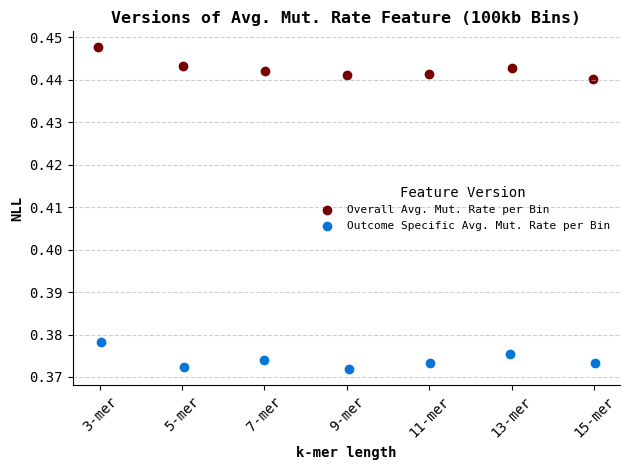

In [63]:
plt.rcParams.update({'font.family': 'monospace'})

x_labels = ["3-mer", "5-mer", "7-mer", "9-mer", "11-mer", "13-mer", "15-mer"]
x_label_map = {"3fA": 0, "5fA": 1, "7fA": 2, "9fA": 3, "11fA": 4, "13fA": 5, "15fA": 6}
jitter = 0.025

colors = {
    "overall_avgmut": mpl.colormaps['cet_glasbey_dark'].colors[15],
    "typespec_avgmut": mpl.colormaps['cet_glasbey_dark'].colors[16]
}

legend_title = {
    "overall_avgmut": "Overall Avg. Mut. Rate per Bin",
    "typespec_avgmut": "Outcome Specific Avg. Mut. Rate per Bin",
}

fig, ax = plt.subplots()

for model in overall_vs_typespec_avgmut_df["model"].unique():
    model_df = overall_vs_typespec_avgmut_df[overall_vs_typespec_avgmut_df["model"] == model]

    # Map data_version to x-axis positions
    x_vals = model_df["data_version"].map(x_label_map).astype(float)
    x_vals += np.random.uniform(-jitter, jitter, size=len(x_vals))

    ax.scatter(
        x=x_vals,
        y=model_df["loss"],
        color=colors[model],
        label=legend_title[model]
    )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.6, zorder=0)
ax.set_title("Versions of Avg. Mut. Rate Feature (100kb Bins)", fontweight='bold')
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("k-mer length", fontweight='bold')
ax.set_ylabel("NLL", fontweight='bold')
ax.legend(title="Feature Version", loc='center right', fontsize=8, frameon=False)

plt.tight_layout()
plt.show()

## Avg mut vs avg mut + bin norm vs all three

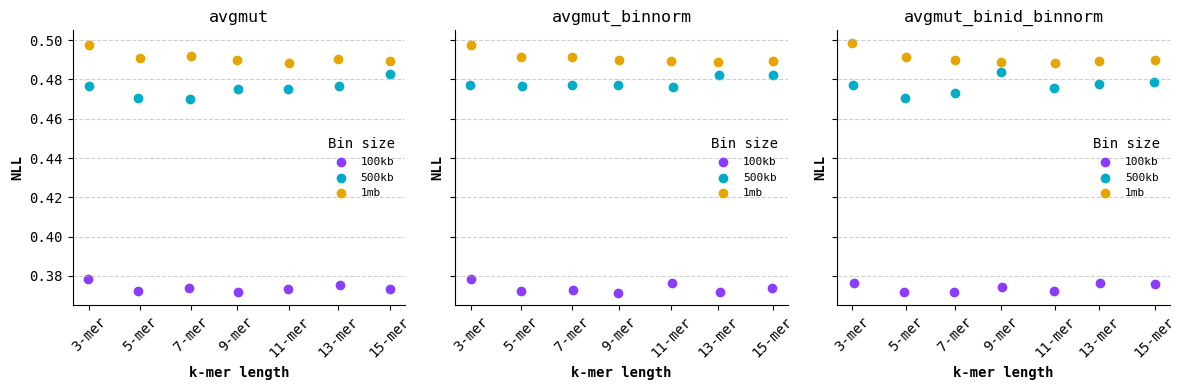

In [66]:
feature_set_order = ["avgmut", "avgmut_binnorm", "avgmut_binid_binnorm"]

# Filter DataFrame and set feature_set as a categorical variable to preserve order
temp_df = combined_losses_df[combined_losses_df["model"].isin(feature_set_order)].copy()
temp_df["feature_set"] = pd.Categorical(temp_df["model"], categories=feature_set_order, ordered=True)

plt.rcParams.update({'font.family': 'monospace'})

x_labels = ["3-mer", "5-mer", "7-mer", "9-mer", "11-mer", "13-mer", "15-mer"]
x_vals = np.arange(len(x_labels)) # Convert labels to integers

binsize_order = ["100kb", "500kb", "1mb"]
temp_df["bin_size"] = pd.Categorical(temp_df["bin_size"], categories=binsize_order, ordered=True)

# Obtain number of different feature sets to group by and facet later
feature_sets = temp_df["model"].unique()
n_feature_sets = len(feature_sets)

colors = {"100kb": mpl.colormaps['cet_glasbey_dark'].colors[1], "500kb": mpl.colormaps['cet_glasbey_dark'].colors[3], "1mb": mpl.colormaps['cet_glasbey_dark'].colors[4]}
# colors = mpl.colormaps['cet_glasbey_dark'].colors
# colors = cc.m_glasbey_dark
jitter = 0.025

fig, axes = plt.subplots(nrows=1, ncols=n_feature_sets, figsize=(4 * n_feature_sets, 4), sharey=True)

for index, (ax, model) in enumerate(zip(axes, feature_sets)):
    sub_df = temp_df[temp_df["model"] == model]

    for bin_size, group in sub_df.groupby("bin_size", observed=True):
        x_vals = x_vals + np.random.uniform(-jitter, jitter, size=len(x_vals))
        ax.scatter(
            x=x_vals,
            y=group["loss"],
            label=bin_size,
            color=colors[bin_size]
        )
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.6, zorder = 0)
    ax.set_title(model)
    ax.set_xticks(x_vals)
    ax.set_xticklabels(x_labels)
    ax.tick_params(axis="x", rotation=45)
    # ax.legend(title="Bin size")
    ax.legend(title="Bin size", loc='center right', fontsize=8, frameon=False)
    ax.set_xlabel('k-mer length', fontweight='bold')
    ax.set_ylabel('NLL', fontweight='bold')

plt.tight_layout()
plt.show()

## Create "mutation outcomes per k-mer type" figure
### Generate list of each possible k-mer context
Only suitable for 3-mers due to number of possible k-mers with higher length

In [ ]:
DATA_VERSION = "3fA"

version_map = {
        "3fA": "3mer_full_A",
        "3fC": "3mer_full_C",
        "3sA": "3mer_subset_A",
        "3sC": "3mer_subset_C",
        "5fA": "5mer_full_A",
        "5fC": "5mer_full_C",
        "7fA": "7mer_full_A",
        "7fC": "7mer_full_C",
        "9fA": "9mer_full_A",
        "9fC": "9mer_full_C",
        "11fA": "11mer_full_A",
        "11fC": "11mer_full_C",
        "13fA": "13mer_full_A",
        "13fC": "13mer_full_C",
        "15fA": "15mer_full_A",
        "15fC": "15mer_full_C",
        "15sA": "15mer_subset_A",
        "15sC": "15mer_subset_C",
        "experiment_full": "experiment_full",
        "experiment_subset": "experiment_subset"
    }

df = pd.read_csv(f"/faststorage/project/MutationAnalysis/Nimrod/data/processed/{version_map[DATA_VERSION]}.tsv", sep="\t")

distinct_contexts = df["context"].drop_duplicates().sort_values(ignore_index=True)
distinct_contexts = list(distinct_contexts)

### Use model.predict_proba() to obtain probability distribution of mutation outcomes for each k-mer type

In [ ]:
model = FCNNEmbedding(num_embeddings=4, embedding_dim=32)
model.load_state_dict(torch.load(f"/faststorage/project/MutationAnalysis/Nimrod/results/models/fc/{DATA_VERSION}/model.pth"))

probs = []

def one_hot_encode_3mer(context):
    nucleotides = ['A', 'C', 'G', 'T']
    nuc_to_int = {nuc: i for i, nuc in enumerate(nucleotides)} # Encode nucl to int
    onehot_array = np.concatenate([np.eye(4)[nuc_to_int[nuc]] for nuc in context])
    return torch.as_tensor(onehot_array, dtype=torch.float32)


for context in distinct_contexts:
    context_onehot = one_hot_encode_3mer(context)
    model.eval()
    with torch.no_grad():
        prob_distr = model.predict_proba(context_onehot).detach().numpy()
        probs.append(prob_distr)

nucleotides = ['A', 'C', 'G', 'T']
probs = pd.DataFrame(probs, columns=nucleotides, index=distinct_contexts)
probs

,A,C,G,T
AAAAA,0.918009,0.019695,0.049612,0.012684
AAAAC,0.932160,0.019248,0.034156,0.014435
AAAAG,0.919127,0.024437,0.042907,0.013529
AAAAT,0.918691,0.024032,0.034005,0.023273
AAACA,0.886547,0.017345,0.076713,0.019395
...,...,...,...,...
TTAGT,0.873586,0.031941,0.072503,0.021970
TTATA,0.790410,0.016034,0.154482,0.039075
TTATC,0.817766,0.020132,0.115807,0.046295
TTATG,0.816581,0.020348,0.117160,0.045911


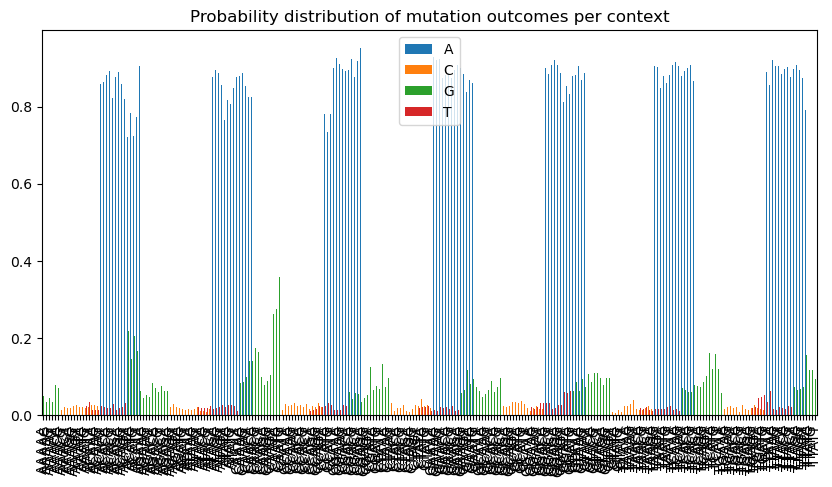

In [7]:
probs.plot(kind="bar", figsize=(10, 5))
plt.title("Probability distribution of mutation outcomes per context")
plt.show()